<h1><center> Construcción de un Forecast Model basado en la venta de artículos marca Apple</center></h1>

#Entendimiento de los datos 🤔

Análisis exploratorio inicial CUALITATIVO. Lo primero que se tiene que hacer es revisar la naturaleza de los datos, que corresponde a las caracteristicas o columnas presentes en el archivo a importar, revisar el formato o tipo de dato que tienen, valores nulos, repetidos, entre otras cosas. Sin embargo lo primordial radicará en conocer nuestros datos lo suficiente paraque, si es el caso, podamos realizar las transformaciones necesarias para llevar a cabo nuestras predicciones.

# Carga de datos 📂

El primer paso es obtener los datos, en este caso se usa la función load_data, la cual se encuentra definida al final de esta libreta, esta función recibe como argumentos la ruta donde se encuentra el archivo que se desea cargar y el nombre del archivo que se desea cargar. La función devuelve un DataFrame de pandas con los datos, este DataFrame se guarda con el nombre "data".

In [ ]:
data = load_data('Path to data', 'Aple_historicaldata_5years.csv')

Ahora se observan las primeras dos filas de los datos para poder conocer un poco más sobre el contenido de este DataFrame

In [ ]:
data.head(2)

,Date,Close/Last,Volume,Open,High,Low
0,09/29/2023,$171.21,51861080,$172.02,$173.07,$170.341
1,09/28/2023,$170.69,56294420,$169.34,$172.03,$167.62


Se escribe un archivo de excel llamada "out.xlsx", el cual contiene las primeras 5 filas de los datos cargados

In [ ]:
data_5 = data.head(5)
data_5.to_excel('out.xlsx')

Antes de poder usar algoritmos de Machine Learning, se deben poner los datos en un formato adecuado para que el algoritmo pueda aprender de ellos, además de esto, se deben eliminar valores NaN u otros valores que pudieran afectar al desempeño del modelo, esto se realiza en la sección de limpieza y preparación de los datos.

# Limpieza y preparación de datos 🧹

## Exploración 🔎

Usando la función data_exploration() definida al final de este documento se puede obtener un análisis de todas las columnas en el DataFrame, esta función brinda información como el tipo de datos presentes en cada columna, el número de valores nulos y el número de valores únicos. La función data_exploration() devulve un DataFrame con los datos antes mencionados

In [ ]:
data_exploration(data)

,Date,Close/Last,Volume,Open,High,Low
type,categorical,categorical,numeric,categorical,categorical,categorical
null_counts,0,0,0,0,0,0
uniques,1258,1209,1258,1213,1217,1227


## Preparación 👍

Usando la función select_columns() definida al final del documento se seleccionan las columnas de "Fecha_Emision" y "Codigo_Producto" del DataFrame "data". Esta función devuelve un DataFrame con las columnas seleccionadas. El DataFrame obtenido con las columnas seleccionadas se guarda con el nombre "data_productos". Además, se muestran las dos primeras columnas del DataFrame "data_productos".

In [ ]:
# Selección de datos - Exp 1 Ventas de productos
data_productos = select_columns(data, ['Date', 'Open'])
data_productos.head(2)

,Date,Open
0,09/29/2023,$172.02
1,09/28/2023,$169.34


De la celda anterior se observa que el producto más vendido es el que tiene el código "M24", por esto, ahora se crea un nuevo DataFrame llamado "data_ventas_producto", este DataFrame contiene el número de ventas del producto "M24" para cada fecha. Es importante recalcar que esto es solo para el producto con el código "M24".

En adición a lo anterior, se copia el DataFrame "data_ventas_producto", esta copia se guarda en un DataFrame llamado "df", a este DataFrame "df" se le agrega una columna con el nombre de "y", en esta columna se copia la columna de "count", pero con los valores movidos una fila hacia abajo, esto para que las ventas parezcan haber sucedido en la fecha siguiente. Esto es lo que se busca predecir con el modelo de Machine Learning, la columna "y" usando la columna "count". Al mover los valores una fila hacia abajo, la primera fila quedará con un valor NaN, este valor se puede remover o rellenar con algún valor. Más adelante se muestra lo que se hizo con este valor en este caso.

A lo anterior se le conoce como "lag features". Se crea una lag feature cuando se mueven las observaciones de tal forma que estas parecen haber ocurrido más tarde en el tiempo. Más adelante se explica por qué usar este tipo de características en este caso.
Para este experimento se usó una lag feature de un paso, es decir, los datos se movieron solo una fila hacia abajo, sin embargo, se pueden usar lag features de más pasos, moviendo los datos más filas hacia abajo, más adelante se muestra esto.

In [ ]:
# Eliminar el símbolo '$' de la columna 'Open' y convertir a numérico
data_productos.loc[:, 'Open'] = data_productos['Open'].str.replace('$', '').astype(float)

# Convertir la columna de fechas al formato '%Y-%m-%d'
data_productos.loc[:, 'Date'] = pd.to_datetime(data_productos['Date'], format='%m/%d/%Y')

# Establecer 'Date' como índice
data_productos.set_index('Date', inplace=True)

# Cambiar el nombre de la columna 'Open' a 'Count'
data_ventas_producto = data_productos.rename(columns={'Open': 'Count'})

df = data_ventas_producto.copy()
df['y'] = df['Count'].shift(1)

df.index.name = None

<ipython-input-18-29bb767d5cd2>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_productos.loc[:, 'Open'] = data_productos['Open'].str.replace('$', '').astype(float)
<ipython-input-18-29bb767d5cd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_productos.loc[:, 'Open'] = data_productos['Open'].str.replace('$', '').astype(float)
<ipython-input-18-29bb767d5cd2>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if 

Para observar si los datos que se tienen cuentan con algún tipo de periodo o tendencia, se grafican estos datos. En el eje x se encuentran las fechas de las entas y en el eje y se encuentra el número de ventas para cada fecha, recordando que en este caso solo se consideran las ventas del producto con el código "DSCTO".

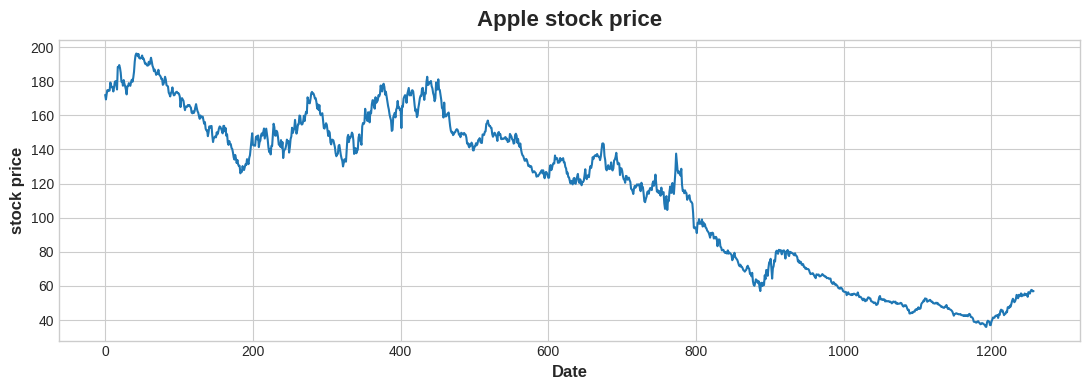

In [ ]:
x = [i for i in range(len(data_ventas_producto))]
y = data_ventas_producto

labels = data_ventas_producto.index[x[::120]]

plt.title('Apple stock price')
plt.xlabel('Date')
plt.ylabel('stock price')
#plt.xticks(x, labels, rotation=45)
plt.locator_params(axis='x', nbins=len(labels))
plt.plot(x, y)
plt.tight_layout(pad=4)
plt.subplots_adjust(bottom=0.15)
plt.show()

De la gráfica anterior se observa que los datos no cuentan con algún periodo ni muestran alguna tendencia, por lo que es posible que los datos no tengan dependencia temporal, es decir que las ventas no dependan de la fecha en la que suceden, sino que los datos tengan dependencia serial, es decir, el número de ventas para la fecha actual depende altamente del número de ventas de la fecha anterior.



Al trabajar con datos temporales hay dos tipos de características que se pueden usar: time-step features y lag features.

Las time-step features permiten modelar dependencia temporal. Existe dependencia temporal cuando los valores de las observaciones se pueden predecir del tiempo en el que estas observaciones ocurrieron.

Por otra parte, las lag features permiten modelar una dependencia serial. Existe dependencia serial cuando una observación se puede predecir a partir del valor de la observación anterior.

En este caso se probará predecir las ventas usando lag features, ya que como se mencionó previamente, los datos no cuentan con algún periodo ni muestran alguna tendencia, por lo que es posible que los datos no tengan dependencia temporal.

A continuación, se muestran los lag plots para un lag desde 1 a 12 pasos. Un lag plot de datos temporales muestra los valores de la serie temporal graficados contra sus lags. En este caso, para cada gráfica en la siguiente celda, en el eje x se encuentran los lags de 1 a 12 pasos respectivamente, y el el eje y se encuentra la cuenta de ventas para cada fecha.

Los lag plots usualmente son útiles para hacer aparente la dependencia serial de datos temporales.

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

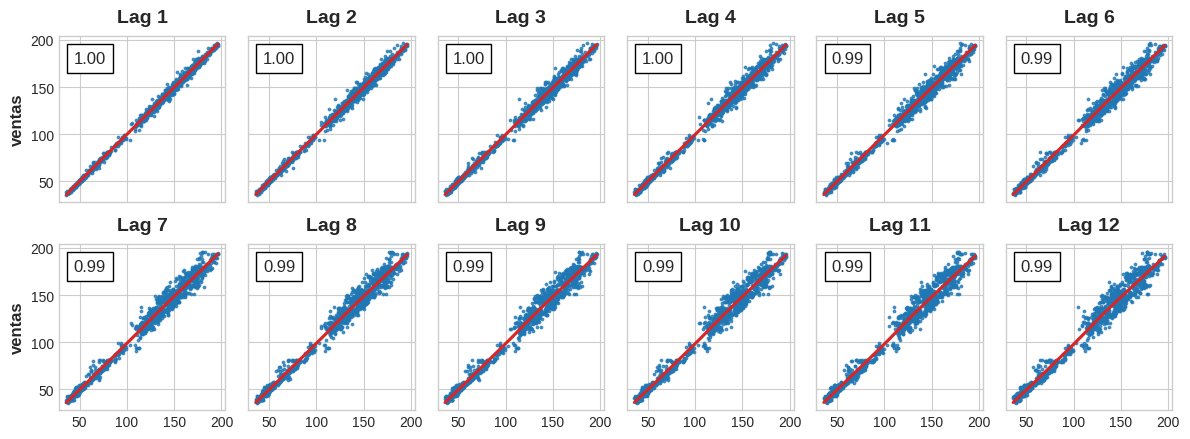

In [ ]:
# Hacer lag plots
_ = plot_lags(data_ventas_producto["Count"], lags=12, nrows=2)

De los lag plots anteriores se observa que las lags features del 1 al 12 tienen cierto comportamiento lineal, debido a esto, es posible que las lags features sí puedan ser útiles para predecir las ventas.

En la parte superior izquierda de cada lag plot se muestra la correlación lineal entre cada lag feature y la cuenta de productos vendidos. Se observa que todas las lag features tienen una correlación lineal con la cuenta de productos vendidos de alrededor de 0.45, esto puede confirmar lo mencionado en el parrafo anterior.

Para elegir el número de lag features que se usarán, usualmente no es muy útil elegir todas las lag features con una correlación alta, esto debido a que puede que por ejemplo, la correlación de la lag feature 2 sea resultado de información deteriorada de la lag feature 1, es decir, la correlación de la lag feature 2 es correlación que se transfiere de la lag feature antereior, por lo que si la lag feature 2 no contiene información nueva, no será útil incluirla si ya se incluyó la lag feature 1. Para solucionar esto se usa la autocorrelación parcial, la autocorrelación parcial indica la cantidad de "nueva" correlación que una lag feature contribuye. Con esto se pueden elegir las lag features que tengan una autocorrelación parcial mayor.

La autocorrelación parcial de cada lag feature se muestra en la siguiente gráfica, esta gráfica se conoce como correlograma.

<a name="correlograma"></a>

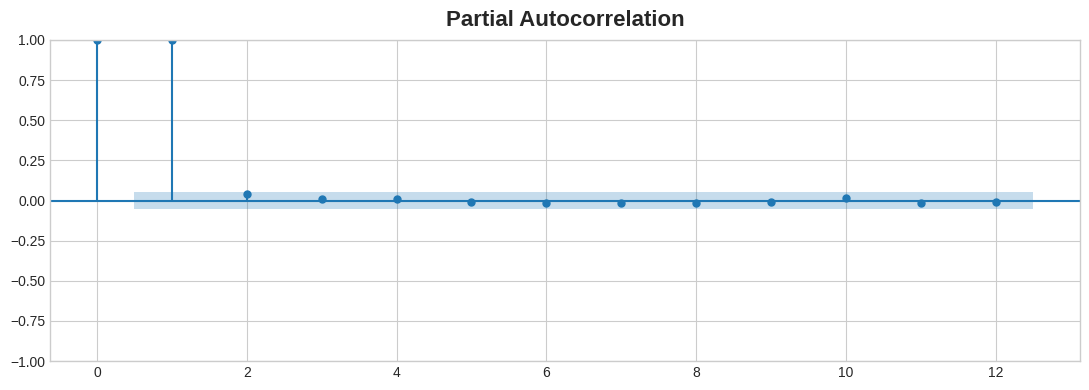

In [ ]:
_ = plot_pacf(data_ventas_producto["Count"], lags=12)

En el correlograma, las lag features que se encuentran dentro del rectangulo azul aportan solo el 5% de correlación como máximo. Se puede observar que las lag features que aportan más correlación son las lag features del 1 al 7, por esto se usaran 7 lag features.

En la siguiente celda se define la función "crear_lag", esta función recibe como entrada una Serie de pandas con los datos a los que se les quiere crear la lag features y el número de lag features que se desea crear, la función devuelve un DataFrame con los datos temporales y las lag features.

In [ ]:
def crear_lag(len_lag: int, data: pd.Series) -> pd.DataFrame:

    df = data.to_frame()
    for i in range(len_lag):
        df[f'x_{i+1}'] = df["Count"].shift(i+1)
    return df

En este caso se crea un DataFrame con 7 lag features, debido a lo que se discutió anteriormente. El DataFrame con las 7 lag features se guarda como "lag_7"

In [ ]:
# Crear dataset con ventana de 12
lag_7 = crear_lag(7, data_ventas_producto["Count"])
lag_7.head()

,Count,x_1,x_2,x_3,x_4,x_5,x_6,x_7
Date,,,,,,,,
2023-09-29,172.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,169.34,172.02,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,172.62,169.34,172.02,NaN,NaN,NaN,NaN,NaN
2023-09-26,174.82,172.62,169.34,172.02,NaN,NaN,NaN,NaN
2023-09-25,174.20,174.82,172.62,169.34,172.02,NaN,NaN,NaN


Como se observa en la celda anterior, al crear las lag features algunas filas quedan con valores NaN, por lo que se debe hacer algo con estos valores para poder usar el DataFrame para entrenar un modelo de Machine Learning. Algunas de las opciones para eliminar los valores NaN son: eliminar las filas que contengan valores NaN, rellenar los valores NaN con ceros, rellenar los valores NaN con la primera observacion, etc.

<a name="rellenar"></a>

En este caso, para evitar perder datos al eliminar valores NaN y tener un dataset más reducido, se rellenan los valores NaN con ceros como se muestra en la siguiente celda.

In [ ]:
# Rellenar NaN values con 0
lag_7.fillna(0, inplace=True)
lag_7.head()

,Count,x_1,x_2,x_3,x_4,x_5,x_6,x_7
Date,,,,,,,,
2023-09-29,172.02,0.00,0.00,0.00,0.00,0.0,0.0,0.0
2023-09-28,169.34,172.02,0.00,0.00,0.00,0.0,0.0,0.0
2023-09-27,172.62,169.34,172.02,0.00,0.00,0.0,0.0,0.0
2023-09-26,174.82,172.62,169.34,172.02,0.00,0.0,0.0,0.0
2023-09-25,174.20,174.82,172.62,169.34,172.02,0.0,0.0,0.0


Para entrenar un modelo de Machine Learning para predicción (aprendizaje supervisado) es necesario pasarle a este por separado las features o características de las que debe aprender y la salida esperada o target para cada feature, para que el modelo pueda ajustar los parámetros si es que las predicciones no son cercanas a los targets.

Por esto, en la siguiente celda se separan del DataFrame "lag_7" las lag features que se usarán como features y se almacenan en la variable "X", por otra parte, se usarán como targets la cuenta de productos vendidos, esta se almacena en la variable "y"

In [ ]:
# Separar features y targets
y = lag_7.pop("Count")
X = lag_7

Ahora se divide el dataset en dos subsets, uno para entrenar el modelo y el otro para evaluar al modelo, estos subsets se conocen como set de entrenamiento y set de prueba, respectivamente.

Lo anterior es importante ya que el modelo debe evaluarse con datos que no haya visto antes, es decir, datos que no son parte del conjunto de datos con el que se entrenó, esto para evitar sesgar la evaluación y que pueda parecer que el modelo tiene un buen desempeño cuando en realidad puede estar "memorizando" los datos.

Esto se hace usando la función "train_test_split" de sklearn a la cual se le pasan las features y targets que se quieren dividir en entrenamiento y prueba, el tamaño del set de prueba que en este caso será el 10% del total de datos disponibles, y si se quieren mezclar o no los datos antes de dividir el dataset, en este caso, al estar trabajando con datos temporales, no se mezclan los datos ya que es importante el orden en el que estos están. La función devuelve las features para entrenamiento y para prueba, y los targets para entrenamiento y para prueba, lo anterior se almacena en las variables "X_train", "X_test", "y_train" y "y_test", respectivamente.

In [ ]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

Para poder tener un resultado de referencia con el cual comparar los resultados del modelo, se crea una Serie de panda con el nombre "baseline_pred". En esta variable se almacenan los valores de la lag feature 1 del set de prueba, es decir, la cuenta de productos vendidos retrasada por un dia.
Esto quiere decir que se tomarán como predicciones de ventas para el día actual la cuenta de ventas del día anterior.

Contra estas predicciones baseline se compararán las predicciones realizadas por el modelo.

In [ ]:
baseline_pred = X_test["x_1"]
baseline_pred

Date
2019-04-02    48.3125
2019-04-01    47.7725
2019-03-29    47.9100
2019-03-28    47.4575
2019-03-27    47.2375
               ...   
2018-10-05    55.5525
2018-10-04    56.9900
2018-10-03    57.6950
2018-10-02    57.5125
2018-10-01    56.8125
Name: x_1, Length: 126, dtype: float64

Ahora que ya se ha hecho el preprocesamiento de los datos, y se han obtenido las características que se usarán se puede pasar a entrenar el modelo para predicción.

# Modelos *forecast* 📈

Para realizar las predicciones de ventas se entrenarán tres modelos y se evaluarán ambos para determinar cuál de estos tres modelos es mejor para realizar las predicciones. Los tres modelos que se entrenarán son:

- Árbol de decisión
- Regresor de Gradient Boosting
- Redes Neuronales LSTM


##Construcción del modelo 🔨

A continuación, se inicializa cada uno de los modelos, se entrena el modelo con los datos de entrenamiento previamente obtenidos y se realizan predicciones sobre el set de prueba con el modelo entrenado.

Primero se construye el árbol de decisión. Las predicciones del árbol de decisión se guardan en la variable "dt_pred".

Probar escalando los datos

In [ ]:
# Importar el modelo de sklearn
from sklearn.tree import DecisionTreeRegressor

# Inicializar el modelo
dt_reg = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
dt_reg.fit(X=X_train, y=y_train)

# Realizar predicciones sobre el set de prueba
dt_pred = dt_reg.predict(X_test)

# Mostrar las predicciones del modelo
dt_pred

array([48.675 , 48.4875, 46.6275, 46.5675, 46.5675, 49.3548, 46.6275,
       46.6275, 46.6275, 46.5675, 45.77  , 49.3548, 46.9275, 46.9275,
       43.86  , 46.9275, 46.9275, 44.105 , 44.105 , 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875, 44.4875,
       44.4875, 44.4875, 44.4875, 44.4875, 44.95  , 46.165 , 45.88  ,
       46.7325, 45.05  , 44.105 , 44.4875, 44.4875, 44.95  , 44.73  ,
       46.5675, 46.5675, 49.3548, 46.6275, 46.6275, 50.1   , 52.7225,
       51.0725, 52.4

Ahora se construye el modelo de Gradient Boosting Regressor. Las predicciones de este modelo se guardan en la variable "gbr_pred".

In [ ]:
# Importar el modelo de sklearn
from sklearn.ensemble import GradientBoostingRegressor

# Inicializar el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gbr.fit(X_train, y=y_train.ravel())

# Realizar predicciones sobre el set de prueba
gbr_pred = gbr.predict(X_test)

# Mostrar las predicciones
gbr_pred

array([48.07121603, 48.07121603, 48.07121603, 48.07121603, 48.07121603,
       48.07121603, 48.07121603, 48.07121603, 48.8253367 , 48.07121603,
       46.67249989, 48.07121603, 46.67249989, 46.67249989, 45.55082435,
       45.55082435, 45.43383906, 44.99347639, 44.99347639, 45.17086639,
       45.17086639, 45.17086639, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32286097,
       45.32286097, 45.32286097, 45.32286097, 45.32286097, 45.32

In [ ]:
# Reshape de la data para pasarla a la LSTM
X_train_lstm = X_train.to_numpy().reshape((-1, X_train.shape[1], 1))
X_test_lstm = X_test.to_numpy().reshape((-1, X_test.shape[1], 1))

In [ ]:
# Construir modelo de LSTM
lstm = Sequential()
lstm.add(LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1:])))
lstm.add(Dense(1))

# Configurar el modelo para el entrenamiento
"""
Optimizador: Adam
learning_rate: 0.0001
loss: mse
metrica: mse
"""
lstm.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenar el modelo por 20 epocas
historia_lstm = lstm.fit(X_train_lstm, y_train, batch_size=32, epochs=1000, verbose=1)

Epoch 1/1000
36/36 [==============================] - 2s 6ms/step - loss: 11906.1572 - mse: 11906.1572
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 100.6780 - mse: 100.6780
Epoch 3/1000
36/36 [==============================] - 0s 5ms/step - loss: 48.7582 - mse: 48.7582
Epoch 4/1000
36/36 [==============================] - 0s 6ms/step - loss: 38.0617 - mse: 38.0617
Epoch 5/1000
36/36 [==============================] - 0s 5ms/step - loss: 36.7187 - mse: 36.7187
Epoch 6/1000
36/36 [==============================] - 0s 5ms/step - loss: 36.2793 - mse: 36.2793
Epoch 7/1000
36/36 [==============================] - 0s 6ms/step - loss: 35.6633 - mse: 35.6633
Epoch 8/1000
36/36 [==============================] - 0s 6ms/step - loss: 36.7862 - mse: 36.7862
Epoch 9/1000
36/36 [==============================] - 0s 6ms/step - loss: 36.2494 - mse: 36.2494
Epoch 10/1000
36/36 [==============================] - 0s 6ms/step - loss: 36.4983 - mse: 36.4983
Epoch 11/1000
36/36 [

In [ ]:
# Realizar predicciones sobre el set de prueba
lstm_pred = lstm.predict(X_test)
lstm_pred = lstm_pred.reshape(len(lstm_pred))

# Mostrar las predicciones
lstm_pred

4/4 [==============================] - 0s 4ms/step


array([47.731472, 47.28202 , 47.193626, 46.88838 , 46.58949 , 46.486115,
       46.91023 , 46.989048, 47.56607 , 46.917053, 46.190643, 46.401417,
       46.04088 , 45.62612 , 45.36951 , 45.04471 , 44.594967, 43.787548,
       42.82955 , 42.96538 , 43.183056, 43.156006, 43.144085, 42.893795,
       42.943317, 42.7867  , 42.791386, 42.881992, 42.430595, 42.351357,
       42.298008, 41.981102, 42.155476, 41.95138 , 42.11604 , 42.004932,
       42.05668 , 41.805325, 42.2649  , 42.880054, 42.53033 , 41.62854 ,
       41.40666 , 41.31124 , 40.668777, 39.39994 , 38.967514, 38.87527 ,
       38.430046, 38.249466, 38.56126 , 38.820206, 38.300648, 38.009747,
       37.608273, 37.552635, 37.82704 , 37.727726, 37.5011  , 37.21078 ,
       37.044483, 36.346844, 36.008854, 37.671192, 38.67997 , 38.70564 ,
       38.60561 , 37.325687, 37.155346, 38.49526 , 39.164406, 40.32877 ,
       40.741352, 40.65817 , 41.49868 , 41.907505, 41.840263, 42.082302,
       41.12879 , 42.33034 , 42.542126, 43.786125, 

In [ ]:
#Adaboost regresor

# Importar el modelo de sklearn
from sklearn.ensemble import AdaBoostRegressor

# Inicializar el modelo
model_Adaboost =  AdaBoostRegressor()

# Entrenar el modelo
model_Adaboost.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
ADA_pred = model_Adaboost.predict(X_test)

# Mostrar las predicciones
ADA_pred


array([49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12959259,
       49.12959259, 49.12959259, 49.12959259, 49.12959259, 49.12

In [ ]:
#Random Forest

# Importar el modelo de sklearn
from sklearn.ensemble import RandomForestRegressor

# Inicializar el modelo
model_RF = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Entrenar el modelo
model_RF.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
RF_pred = model_RF.predict(X_test)

# Mostrar las predicciones
RF_pred

array([48.51661493, 48.12963271, 47.90412662, 47.38832848, 47.28080432,
       47.45495886, 47.57897825, 47.62690358, 47.97938705, 47.35812499,
       46.40590081, 47.92157436, 46.30385703, 46.15348686, 45.70800061,
       45.42873585, 44.93358568, 44.51153518, 44.38135101, 44.64811042,
       44.75478542, 44.75733958, 44.94315625, 44.9833875 , 44.9833625 ,
       45.0067125 , 45.0082125 , 45.0300625 , 45.0296625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 ,
       44.9815625 , 44.9815625 , 44.9815625 , 44.9815625 , 44.98

In [ ]:
#XGBOOST

# Importar el modelo de sklearn
import xgboost as xgb

# Inicializar el modelo
model_xgboost = xgb.XGBRegressor(objective='reg:squarederror')

# Entrenar el modelo
model_xgboost.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
XGB_pred = model_xgboost.predict(X_test)

# Mostrar las predicciones
XGB_pred

array([48.01044 , 48.286324, 47.69792 , 47.56314 , 47.563675, 47.480816,
       47.509796, 47.676662, 48.954414, 48.178608, 46.579643, 47.949223,
       46.077698, 46.288372, 44.94125 , 45.542393, 45.22886 , 44.101704,
       44.500187, 44.500187, 44.354404, 44.558884, 44.354404, 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 , 44.89899 ,
       44.89899 , 44.89899 , 44.89899 , 45.324013, 

In [ ]:
#LightGBM

# Importar el modelo de sklearn
import lightgbm as lgb

# Inicializar el modelo
model_lgb = lgb.LGBMRegressor()

# Entrenar el modelo
model_lgb.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
LGB_pred = model_lgb.predict(X_test)

# Mostrar las predicciones
LGB_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 7
[LightGBM] [Info] Start training from score 123.969276


array([48.37453101, 47.40695869, 47.13144588, 46.14904458, 45.63385784,
       44.30428476, 45.43840137, 50.16840927, 50.16840927, 50.16840927,
       50.16840927, 50.16840927, 50.16840927, 49.5494794 , 48.25625311,
       50.16840927, 55.00071828, 51.65668792, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00071828,
       55.00071828, 55.00071828, 55.00071828, 55.00071828, 55.00

## Comparación de los modelo 📊

Una vez se tienen los dos modelos entrenados y se han obtenido las predicciones de ambos, es necesario comparar estos dos modelos para determinar cuál obtiene los mejores resultados y usar este modelo para las predicciones de las ventas.

Para poder comparar los modelos se necesita elegir una métrica de desempeño con la cual se evaluará cada uno de los modelo. En este caso se usará como métrica de desempeño el error absoluto medio porcentual (MAPE), el cual se define por la siguiente expresión:

\begin{align}
        MAPE = \frac{1}{n} \sum_{i=1} ^{n} \frac{\mid y_i - \hat{y_i} \mid}{\mid y_i \mid}
    \end{align}

Donde:
- $n$ es el número de datos en el set
- $y_i$ es el valor real de la observación (targets)
- $\hat{y_i}$ es el valor predicho de la observación

Un MAPE cercano a cero indica que el modelo realiza buenas predicciones, que se acercan mucho a los targets.

En la siguiente función se define la funcion "mape", la cual recibe como entrada los targets y las predicciones del modelo. Como su nombre lo indica, la función devuelve el MAPE.

In [ ]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)), 2)
  #return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

En la siguiente celda se calcula el MAPE de la predicción baseline, el MAPE de las predicciones del árbol de decisión y el MAPE de las predicciones del Gradient Boosting Regressor.

Además de esto, se grafican cada uno de estos MAPES para observar cuales son las predicciones más cercanas a los targets.

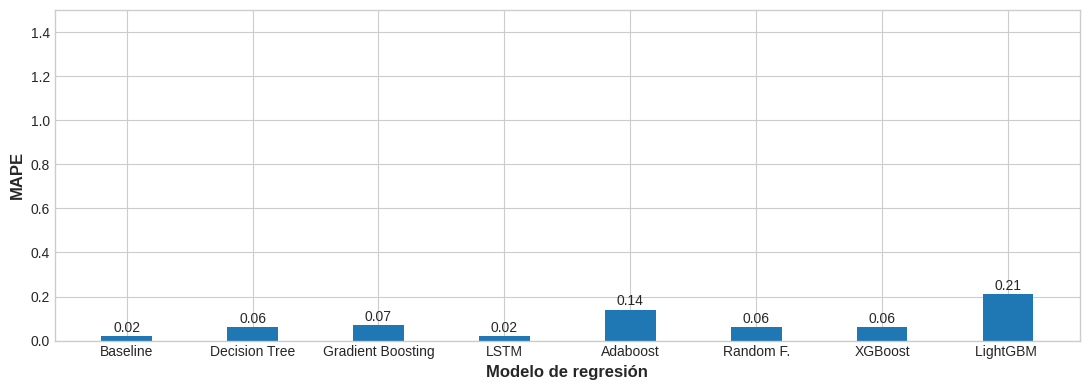

In [ ]:
# Calcular los mape del baseline, el arbol de decision y el Gradient Boosting
baseline_mape = mape(y_test, baseline_pred)
dt_mape = mape(y_test, dt_pred)
gbr_mape = mape(y_test, gbr_pred)
lstm_mape = mape(y_test, lstm_pred)
ada_mape = mape(y_test, ADA_pred)
rf_mape = mape(y_test, RF_pred)
xgb_mape = mape(y_test, XGB_pred)
gbm_mape = mape(y_test, LGB_pred)

# Graficar los mape
fig, ax = plt.subplots()
x = ['Baseline', 'Decision Tree', 'Gradient Boosting', "LSTM", 'Adaboost', 'Random F.', 'XGBoost', 'LightGBM ']
y = [baseline_mape, dt_mape, gbr_mape, lstm_mape, ada_mape, rf_mape, xgb_mape, gbm_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Modelo de regresión')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 1.5)

# Agregar el MAPE a la grafica
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')

plt.tight_layout()

De la gráfica anterior se observa que el modelo que obtuvo el menor MAPE, y por lo tanto tiene el mejor desempeño es el modelo de Gradient Boosting, con un MAPE de 0.47, este MAPE es mejor que el de las predicciones baseline, cuyo MAPE es de 0.49, al igual que el de la LSTM. Por otra parte, el peor modelo fue el del árbol de decisión, con un MAPE de 0.51.

## Probar usando 6 lag features 6️⃣

Aunque el modelo de Gradient Boosting logra superar a las predicciones baseline, el MAPE que este modelo obtiene todavía no es tan pequeño como se esperaría, por lo tanto, ahora se probará usando solo 6 lag features, ya que en el [correlograma](#correlograma) se muestra que a partir de la lag feature 6 las autocorrelaciones parciales comienzan a disminuir.

Para esto se usa nuevamente la función "crear_lag", el DataFrame con las 6 lag features se almacena en la variable "lag_6".

In [ ]:
# Crear dataset 6 lag features
lag_6 = crear_lag(6, data_ventas_producto["Count"])
lag_6.head()

,Count,x_1,x_2,x_3,x_4,x_5,x_6
Date,,,,,,,
2023-09-29,172.02,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,169.34,172.02,NaN,NaN,NaN,NaN,NaN
2023-09-27,172.62,169.34,172.02,NaN,NaN,NaN,NaN
2023-09-26,174.82,172.62,169.34,172.02,NaN,NaN,NaN
2023-09-25,174.20,174.82,172.62,169.34,172.02,NaN,NaN


Nuevamente, debido al retraso añadido a los datos para crear las lag features, se pueden observar algunos NaN values, estos se rellenan con ceros por lo [mencionado](#rellenar) antes.

In [ ]:
# Rellenar nan values con 0
lag_6.fillna(0, inplace=True)
lag_6.head()

,Count,x_1,x_2,x_3,x_4,x_5,x_6
Date,,,,,,,
2023-09-29,172.02,0.00,0.00,0.00,0.00,0.0,0.0
2023-09-28,169.34,172.02,0.00,0.00,0.00,0.0,0.0
2023-09-27,172.62,169.34,172.02,0.00,0.00,0.0,0.0
2023-09-26,174.82,172.62,169.34,172.02,0.00,0.0,0.0
2023-09-25,174.20,174.82,172.62,169.34,172.02,0.0,0.0


El siguiente paso es separar de nuevo los features y los targets del DataFrame "lag_6".

In [ ]:
# Separar features y targets
y = lag_6.pop("Count")
X = lag_6

Ahora que ya se tienen las features y los targets separados, se deben dividir estos en entrenamiento y prueba, así como se realizó antes, se deja el 10% del total de datos para prueba, y los datos no se mezclan antes de dividirlos ya que se está trabajando con datos temporales y el orden de los datos es importante.

In [ ]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

Ahora se crea la predicción baseline, en este caso en vez de tomar como predicción el número de ventas del día anterior, se toma como predicción baseline el promedio de las lag features. Nuevamente, este baselinse se almacena como "baseline_pred".

In [ ]:
# Usar como baseline le promedio de los lags
baseline_pred = []

for row in X_test.values:
    baseline_pred.append(np.mean(row))

Ahora se construye cada uno de los dos modelos, se entrenan y se realizan predicciones con cada uno sobre el set de prueba.

Las predicciones del árbol de decisión se almacenan en la variable "dt_reg_6_pred", mientras que las del Gradient Boosting Regressor se almacenan en la variable "gbr_6_pred".

In [ ]:
# Inicializar el modelo
dt_reg_6 = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
dt_reg_6.fit(X_train, y_train)

# Realizar predicciones con el modelo
dt_reg_6_pred = dt_reg_6.predict(X_test)

In [ ]:
# Inicializar el modelo
gbr_6 = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gbr_6.fit(X_train, y_train.ravel())

# Realizar predicciones con el modelo
gbr_6_pred = gbr_6.predict(X_test)

In [ ]:
# Inicializar el modelo
ada_6 = AdaBoostRegressor(random_state=0, n_estimators=7)

# Entrenar el modelo
ada_6.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
ada_6_pred = ada_6.predict(X_test)

In [ ]:
# Inicializar el modelo
rf_6 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Entrenar el modelo
rf_6.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
rf_6_pred = rf_6.predict(X_test)


In [ ]:
# Inicializar el modelo
xgb_6 = xgb.XGBRegressor(objective='reg:squarederror')

# Entrenar el modelo
xgb_6.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
xbg_6_pred = xgb_6.predict(X_test)

In [ ]:
# Inicializar el modelo
lgb_6 = lgb.LGBMRegressor()

# Entrenar el modelo
lgb_6.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
lgb_6_pred = lgb_6.predict(X_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 6
[LightGBM] [Info] Start training from score 123.969276


In [ ]:
# Reshape de la data para pasarla a la LSTM
X_train_lstm = X_train.to_numpy().reshape((-1, X_train.shape[1], 1))
X_test_lstm = X_test.to_numpy().reshape((-1, X_test.shape[1], 1))

In [ ]:
# Construir modelo de LSTM
lstm = Sequential()
lstm.add(LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1:])))
lstm.add(Dense(1))

# Configurar el modelo para el entrenamiento
"""
Optimizador: Adam
learning_rate: 0.0001
loss: mse
metrica: mse
"""
lstm.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenar el modelo por 20 epocas
historia_lstm = lstm.fit(X_train_lstm, y_train, batch_size=32, epochs=1000, verbose=1)

Epoch 1/1000
36/36 [==============================] - 2s 8ms/step - loss: 8618.9121 - mse: 8618.9121
Epoch 2/1000
36/36 [==============================] - 0s 7ms/step - loss: 69.0993 - mse: 69.0993
Epoch 3/1000
36/36 [==============================] - 0s 8ms/step - loss: 49.5076 - mse: 49.5076
Epoch 4/1000
36/36 [==============================] - 0s 7ms/step - loss: 40.5489 - mse: 40.5489
Epoch 5/1000
36/36 [==============================] - 0s 8ms/step - loss: 43.5393 - mse: 43.5393
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 35.7806 - mse: 35.7806
Epoch 7/1000
36/36 [==============================] - 0s 7ms/step - loss: 34.6785 - mse: 34.6785
Epoch 8/1000
36/36 [==============================] - 0s 8ms/step - loss: 34.6685 - mse: 34.6685
Epoch 9/1000
36/36 [==============================] - 0s 8ms/step - loss: 35.6513 - mse: 35.6513
Epoch 10/1000
36/36 [==============================] - 0s 8ms/step - loss: 36.9438 - mse: 36.9438
Epoch 11/1000
36/36 [====

In [ ]:
# Realizar predicciones sobre el set de prueba
lstm_6_pred = lstm.predict(X_test)
lstm_6_pred = lstm_pred.reshape(len(lstm_6_pred))

# Mostrar las predicciones
lstm_6_pred

4/4 [==============================] - 0s 4ms/step


array([47.731472, 47.28202 , 47.193626, 46.88838 , 46.58949 , 46.486115,
       46.91023 , 46.989048, 47.56607 , 46.917053, 46.190643, 46.401417,
       46.04088 , 45.62612 , 45.36951 , 45.04471 , 44.594967, 43.787548,
       42.82955 , 42.96538 , 43.183056, 43.156006, 43.144085, 42.893795,
       42.943317, 42.7867  , 42.791386, 42.881992, 42.430595, 42.351357,
       42.298008, 41.981102, 42.155476, 41.95138 , 42.11604 , 42.004932,
       42.05668 , 41.805325, 42.2649  , 42.880054, 42.53033 , 41.62854 ,
       41.40666 , 41.31124 , 40.668777, 39.39994 , 38.967514, 38.87527 ,
       38.430046, 38.249466, 38.56126 , 38.820206, 38.300648, 38.009747,
       37.608273, 37.552635, 37.82704 , 37.727726, 37.5011  , 37.21078 ,
       37.044483, 36.346844, 36.008854, 37.671192, 38.67997 , 38.70564 ,
       38.60561 , 37.325687, 37.155346, 38.49526 , 39.164406, 40.32877 ,
       40.741352, 40.65817 , 41.49868 , 41.907505, 41.840263, 42.082302,
       41.12879 , 42.33034 , 42.542126, 43.786125, 

Por último se evaluán estos modelos usando el MAPE, además de graficar los MAPE.

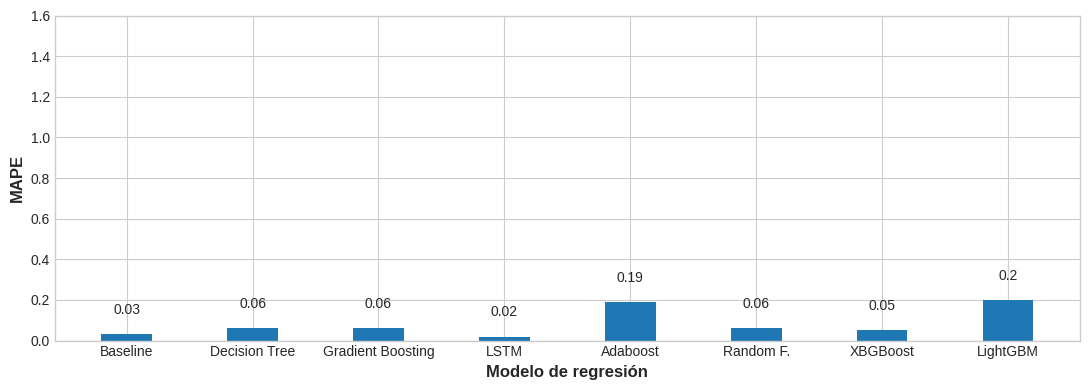

In [ ]:
# Obtener el mape del baseline, el arbol de decision y el gradient boosting regressor
baseline_mape = mape(y_test, baseline_pred)
dt_6_mape = mape(y_test, dt_reg_6_pred)
gbr_6_mape = mape(y_test, gbr_6_pred)
lstm_6_mape = mape(y_test, lstm_6_pred)
ada_6_mape = mape(y_test, ada_6_pred)
rf_6_mape = mape(y_test, rf_6_pred)
xbg_6_mape = mape(y_test, xbg_6_pred)
lgb_6_mape = mape(y_test, lgb_6_pred)

# Graficar los mape
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting', 'LSTM', 'Adaboost', 'Random F.', 'XBGBoost', 'LightGBM']
y = [baseline_mape, dt_6_mape, gbr_6_mape, lstm_6_mape, ada_6_mape, rf_6_mape, xbg_6_mape, lgb_6_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Modelo de regresión')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 1.6)

# Agregar el mape a la tabla
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')

plt.tight_layout()

En esta gráfica se observa que el mejor modelo sigue siendo el Gradient Boosting con un MAPE de 0.46, aunque la disminución del MAPE al usar 6 lag features no fue mucha pues el mape solo disminuyó en 0.01, además de esto este modelo ya no es mejor que el baseline (recordad que ahora el baseline es el promedio de las lag features) cuyo MAPE es de 0.44. Otra cosa que se puede notar es que el modelo de árbol de decisión disminuyo su desempeño al remover la lag feature 7, su MAPE ahora es de 0.55, este muestra un aumento del 0.04 respecto al MAPE obtenido al usar 7 lag features. Por otra parte, la LSTM no se vió afectada al remover el retraso de 7 días, su MAPE permaneció en 0.49.

## Probar con ventana de 7 🪟

Debido a que la no hubo una mejora importante del desempeño del modelo de Gradient Boosting al usar 6 lag features, ahora se probará usando una ventana de 7 lag features. Para esto se usa la función "window_input_output" que se define en la siguiente celda, esta función toma como entrada el tamaño de los retrasos en la entrada (input_length) y el tamaño de los retrasos en la salida (output_length), además de una Serie de pandas con los datos a los que se les quiere aplicar el retraso (data). La función devuelve un DataFrame que contiene la cuenta de las ventas, las lag features desde 1 hasta input_length-1 (estas son las x_n en el DataFrame), y la cuenta retrasada desde output_length hasta 2 veces output_length (estas son las columnas de y_n en el dataframe).

Por último, la función rellena los valores NaN con ceros.

In [ ]:
def window_input_output(input_length: int, output_length: int, data: pd.Series) -> pd.DataFrame:

    df = data.to_frame()

    for i in range(1, input_length):
        df[f'x_{i}'] = df["Count"].shift(i)

    for j in range(output_length):
      df[f'y_{j}'] = df["Count"].shift(output_length + j)

    df = df.fillna(0)

    return df

Usando la función antes descrita se crea una ventana de 7 y se guarda en el DataFrame llamado "seq_df".

In [ ]:
seq_df = window_input_output(7, 7, data_ventas_producto["Count"])

seq_df.head(5)

,Count,x_1,x_2,x_3,x_4,x_5,x_6,y_0,y_1,y_2,y_3,y_4,y_5,y_6
Date,,,,,,,,,,,,,,
2023-09-29,172.02,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-28,169.34,172.02,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-27,172.62,169.34,172.02,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-26,174.82,172.62,169.34,172.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-09-25,174.20,174.82,172.62,169.34,172.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El siguiente paso es separar los features de los targets, en este caso se usan como features las columnas que inician con "x" en el DataFrame "seq_df" y se usan como targets las columnas que inician con "y".

También se divide el conjunto de datos en entrenamiento y prueba, así como en los casos anteriores, no se mezcla el dataset antes de dividirlo y se toma el 10% del total de los datos para prueba.

In [ ]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'Count')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

X_train, X_test, y_train, y_test = train_test_split(seq_df[X_cols].values, seq_df[y_cols].values, test_size=0.1, random_state=42, shuffle=False)

Ahora se construye el modelo de árbol de decisión para predecir los targets. Las predicciones realizadas por el modelo se guardan en la variable "dt_seq_preds"

In [ ]:
# Inicializar el modelo
dt_seq = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
dt_seq.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
dt_seq_preds = dt_seq.predict(X_test)
print(y_train)

[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 ...
 [49.865  49.885  50.78   ... 51.1075 51.84   51.7075]
 [49.645  49.865  49.885  ... 50.7075 51.1075 51.84  ]
 [49.8    49.645  49.865  ... 50.78   50.7075 51.1075]]


Ahora se construye el modelo de Gradient Boosting, sin embargo, se añade una pequeña modificación a este modelo, en este caso se usará la clase *Regressor Chain* de sklearn, esto debido a que ahora no se quiere predecir un solo target, sino 7 targets, en la siguiente celda se muestra la forma de los targets, donde se observa que hay 7 targets a predecir y no solo uno.

In [ ]:
y_train.shape

(1132, 7)

Por esto se usa la clase *Regressor Chain*, permite crear un modelo multi-etiqueta que organiza las regresiones en una cadena.

Con esta clase, cada modelo realiza una predicción en el orden especificado por la cadena usando todas las características de entrada al modelo más las predicciones de los modelos anteriores en la cadena.

Las predicciones obtenidas con esta cadena de Gradient Boosting se guardan en la variable "gbr_sqr_preds"

In [ ]:
# Importar Regressor Chain
from sklearn.multioutput import RegressorChain

# Inicializar el modelo de Gradient Boosting
gbr_seq = GradientBoostingRegressor(random_state=42)

# Crear la cadena con el modelo de Gradient Boosting
chained_gbr = RegressorChain(gbr_seq)

# Entrenar la cadena
chained_gbr.fit(X_train, y_train)

# Realizar predicciones con la cadena
gbr_seq_preds = chained_gbr.predict(X_test)

In [ ]:
# Importar Regressor Chain
from sklearn.multioutput import RegressorChain

# Inicializar el modelo
ada_seq  = AdaBoostRegressor(n_estimators=1000)

chained_ada = RegressorChain(ada_seq)

# Entrenar el modelo
chained_ada.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
ada_seq_pred = chained_ada.predict(X_test)

In [ ]:
# Inicializar el modelo
rf_seq = RandomForestRegressor(n_estimators=100, max_depth=17, random_state=42)

#chained_rf = RegressorChain(rf_seq)

# Entrenar el modelo
rf_seq.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
rf_seq_preds = rf_seq.predict(X_test)


In [ ]:
# Inicializar el modelo
xgb_seq = xgb.XGBRegressor(objective='reg:squarederror')

#chained_xgb = RegressorChain(xgb_seq)

# Entrenar el modelo
xgb_seq .fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
xgb_seq_preds = xgb_seq .predict(X_test)

In [ ]:
# Inicializar el modelo
lgb_seq = lgb.LGBMRegressor()

chained_lgb = RegressorChain(lgb_seq)

# Entrenar el modelo
chained_lgb.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
lgb_seq_preds = chained_lgb.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 7
[LightGBM] [Info] Start training from score 123.664338
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1132, number of used features: 8
[LightGBM] [Info] Start training from score 123.620345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the 

In [ ]:
from sklearn.svm import SVR

# Inicializar el modelo
svr_seq = SVR(kernel='poly', degree = 3)

chained_svr = RegressorChain(svr_seq)

# Entrenar el modelo
chained_svr.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
svr_seq_preds = chained_svr.predict(X_test)

In [ ]:
# Reshape de la data para pasarla a la LSTM
X_train_lstm = X_train.reshape((-1, X_train.shape[1], 1))
X_test_lstm = X_test.reshape((-1, X_test.shape[1], 1))

In [ ]:
# Construir modelo de LSTM
lstm = Sequential()
lstm.add(LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1:])))
lstm.add(Dense(7))

# Configurar el modelo para el entrenamiento
"""
Optimizador: Adam
learning_rate: 0.0001
loss: mse
metrica: mse
"""
lstm.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 10757 (42.02 KB)
Trainable params: 10757 (42.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Entrenar el modelo por 20 epocas
historia_lstm = lstm.fit(X_train_lstm, y_train, batch_size=32, epochs=1000, verbose=1)

Epoch 1/1000
36/36 [==============================] - 2s 5ms/step - loss: 9118.8086 - mse: 9118.8086
Epoch 2/1000
36/36 [==============================] - 0s 6ms/step - loss: 343.7178 - mse: 343.7178
Epoch 3/1000
36/36 [==============================] - 0s 6ms/step - loss: 151.6454 - mse: 151.6454
Epoch 4/1000
36/36 [==============================] - 0s 6ms/step - loss: 144.7164 - mse: 144.7164
Epoch 5/1000
36/36 [==============================] - 0s 5ms/step - loss: 145.7527 - mse: 145.7527
Epoch 6/1000
36/36 [==============================] - 0s 6ms/step - loss: 140.8913 - mse: 140.8913
Epoch 7/1000
36/36 [==============================] - 0s 6ms/step - loss: 138.4203 - mse: 138.4203
Epoch 8/1000
36/36 [==============================] - 0s 6ms/step - loss: 146.7644 - mse: 146.7644
Epoch 9/1000
36/36 [==============================] - 0s 6ms/step - loss: 150.8460 - mse: 150.8460
Epoch 10/1000
36/36 [==============================] - 0s 6ms/step - loss: 144.7567 - mse: 144.7567
Epoch 1

In [ ]:
# Realizar predicciones sobre el set de prueba
lstm_seq_pred = lstm.predict(X_test)

# Mostrar las predicciones
lstm_seq_pred

4/4 [==============================] - 0s 4ms/step


array([[50.286415, 50.217773, 50.754707, 50.577824, 50.559143, 50.55749 ,
        50.859062],
       [50.537964, 50.554184, 51.0252  , 50.852432, 50.91576 , 50.87704 ,
        51.206783],
       [49.672253, 49.65702 , 50.14972 , 49.984024, 50.0093  , 49.983818,
        50.304848],
       [49.639015, 49.6731  , 50.126595, 49.986763, 50.030273, 49.996677,
        50.341995],
       [49.224655, 49.25242 , 49.699837, 49.579014, 49.606438, 49.600094,
        49.94857 ],
       [48.823643, 48.881577, 49.296917, 49.13761 , 49.211006, 49.188786,
        49.52157 ],
       [48.392204, 48.416893, 48.8493  , 48.643326, 48.69983 , 48.725315,
        49.016174],
       [48.4813  , 48.54395 , 48.92577 , 48.681805, 48.7762  , 48.835293,
        49.107407],
       [48.02655 , 48.03424 , 48.432373, 48.14187 , 48.24242 , 48.359215,
        48.603756],
       [47.722443, 47.73418 , 48.123466, 47.946484, 48.00194 , 48.051807,
        48.382484],
       [47.734497, 47.68609 , 48.15041 , 48.083584, 48.03154

Finalmente, se calculan los MAPE del árbol del decisión, la cadena de Gradient Boosting, LSTM y el baseline, en este caso se usa como baseline las features con la ventana de 7 lags, así como en el primer experimento se usó como basline la feature con el lag de 1.

Adicional a esto, se grafican cada uno de estos MAPE.

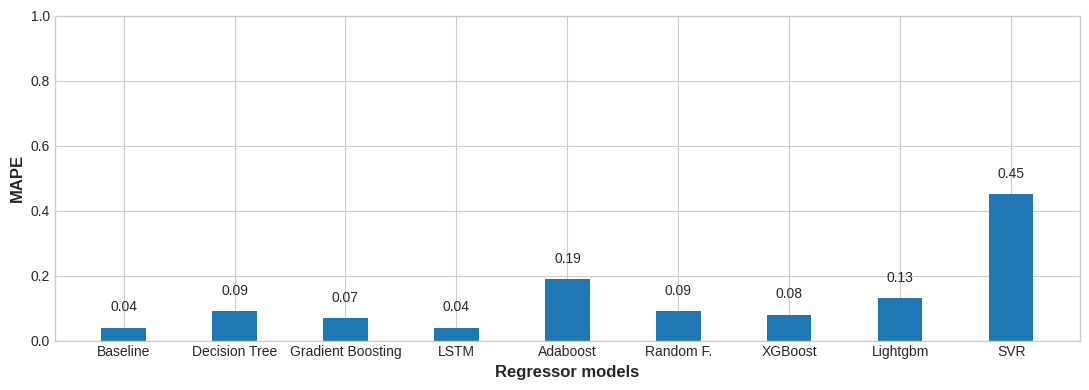

In [ ]:
# Obtener los MAPE del baseline, el arbol de decision y la cadena de Gradient Boosting
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
mape_lstm_seq = mape(lstm_seq_pred.reshape(1, -1), y_test.reshape(1, -1))
mape_ada_seq = mape(ada_seq_pred.reshape(1, -1), y_test.reshape(1, -1))
mape_rf_seq = mape(rf_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_xgb_seq = mape(xgb_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_lgb_seq = mape(lgb_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_svr_seq = mape(svr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))

# Graficar los MAPE
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting', 'LSTM', 'Adaboost', 'Random F.', 'XGBoost', 'Lightgbm', 'SVR']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq, mape_lstm_seq, mape_ada_seq, mape_rf_seq, mape_xgb_seq, mape_lgb_seq, mape_svr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE')
ax.set_ylim(0, 1)

# Agregar los MAPE a las gráficas
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')

plt.tight_layout()

La gráfica anterior muestra que nuevamente el mejor modelo es el de Gradient Boosting (en este caso la cadena de Gradient Boosting) con un MAPE de 0.35, disminuyendo su MAPE 0.11 respecto al experimento anterior, la mejora que obtuvo este modelo al agregar la cadena y la ventana de 7 ahora sí es considerable, además de que superó ampliamente al baseline y al árbol de decisión cuyos MAPE fueron de 0.54 y 0.61, respectivamente. Al agregar la ventana de 7 el modelo de árbol de decisión no mejoro su MAPE, sino que lo empeoró 0.6 respecto al experimento anterior.

Para terminar la sección de predicción de ventas, se muestra la gráfica de los productos vendidos en cada fecha, la predicción del baseline, la predicción del árbol de decisión y la predicción de la cadena de Gradient Boosting para la ventana de 7.

En el eje x se encuentra la fecha y en el eje y el número de ventas.

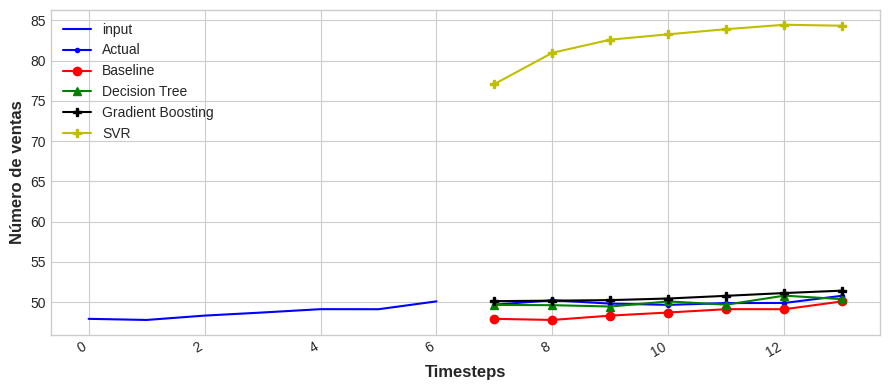

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot( X_test[1], 'b-', label='input')
ax.plot(np.arange(7, 14, 1),y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(7, 14, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(7, 14, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(7, 14, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')
#ax.plot(np.arange(7, 14, 1), ada_seq_pred[1], marker='P', color='m', label='Adaboost')
#ax.plot(np.arange(7, 14, 1), rf_seq_preds[1], marker='P', color='y', label='Random Forest')
#ax.plot(np.arange(7, 14, 1), xgb_seq_preds[1], marker='P', color='orange', label='XGBoost')
#ax.plot(np.arange(7, 14, 1), lgb_seq_preds[1], marker='P', color='pink', label='LightGBM ')
ax.plot(np.arange(7, 14, 1), svr_seq_preds[1], marker='P', color='y', label='SVR')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Número de ventas')
#plt.xticks(np.arange(1, 14, 7), np.arange(2015, 2020, 5))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

# ⚠️ Importante

## Ejecutar esta celda antes de ejecutar *TODAS* las anteriores❗

### Utils

Funciones propias necesarias para ejecutar el código

In [ ]:
# Dependencias
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics.cluster import silhouette_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

<ipython-input-2-b148fd1a2942>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install xgboost
!pip install lightgbm

In [ ]:
def load_data(path:str, file_name:str)->pd.DataFrame:
  # Montar el drive
  path_ = '/content/gdrive/MyDrive/' + path

  type_file = file_name.split('.')[1]

  if type_file == 'xlsx':
    print("loaded file: " + path_ + file_name)
    return pd.read_excel(path_ + file_name)
  elif type_file == 'csv':
    print("loaded file: " + path_ + file_name)
    return pd.read_csv(path_ + file_name, encoding='latin1')
  else:
    raise AttributeError("type file not valid")

def data_exploration(data:pd.DataFrame)-> pd.DataFrame:

  exploration = pd.DataFrame(columns = data.columns,
                           index=['type','null_counts','uniques'])

  # shape of dataframe
  shape = data.shape
  #data['shape rows'] = shape[0]

  # num of nulls per column
  null_counts = data.isnull().sum()
  exploration.loc['null_counts'] = null_counts

  # categorical or numeric data columns
  cat_cols = [col for col in data.columns if col not in data.describe().columns]
  num_cols = data._get_numeric_data().columns
  exploration.loc['type', cat_cols] = 'categorical'
  exploration.loc['type', num_cols] = 'numeric'

  # describe()
  #data.describe()

  # unique values
  exploration.loc['uniques', data.nunique().index] = data.nunique().values


  return exploration

def varianceTreshold_analysis(data:pd.DataFrame) -> np.array:
  # Intuitivamente significa que eliminaremos los atributos que sean igual en proporción mayor o igual a 80%
  sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
  df_2 = pd.DataFrame(sel.fit_transform(data))
  return df_2

def select_columns(data:pd.DataFrame, columns: list)->pd.DataFrame:
  return data[columns]

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :] )
    plt.setp(axs[:, 0], ylabel="ventas")
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def calcular_MI(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores